## Send MWA data to JSON format for training

In [1]:
import sys
sys.path.append('/users/jmduchar/data/jmduchar/Research/mcgill25/rfi_characterization/python/')
from utils import *

import numpy as np
import yaml
import os
import glob
import json
from astropy.io import fits
import h5py
import matplotlib.pyplot as plt
from mapper import bg_subtract
plt.style.use('seaborn-v0_8')

In [2]:
def get_pointing(data, pointing):
    """
    Given a dictionary mapping obsids to pointings, and the desired pointing,
    return *all* obsids for that pointing.

    Parameters:
        data (dict): Dictionary of obsid strings mapped to integer values.
        pointing (int): The desired pointing

    Returns:
        list: Complete list of obsids from that poiting
    """
    result = []
    for i in data:
        if data[i] == pointing:
            result.append(i)

    return result  # return the pointing and all associated obsids for that night

In [3]:
# Get data
dirpath = '/users/jmduchar/data/jmduchar/Research/mcgill25/ssins_data/'
# reference_obs = '1093799552'  # known to contain RFI
# reference_obs = '1094662784'
reference_obs = '1090867840'

with open(dirpath+'gridpoint_dict.yaml', 'r') as file:
    data = yaml.safe_load(file)
    
pointing, obsids = get_night(data=data, target_obsid=reference_obs)
# obsids = get_pointing(data, pointing=0)
# obsids.sort()

len(obsids)

15

In [4]:
subtracted_data = bg_subtract(data_dir=dirpath+'tars/', obsids=obsids, N_terms=24)
subtracted_data = subtracted_data[~np.isnan(subtracted_data)]

subtracted_data.shape

channel_width not available in file, computing it from the freq_array spacing.
Antenna metadata are missing for this file. Since this is MWA data, the best way to fill in these metadata is to pass in an mwa_metafits_file which contains information about which antennas were connected when the data were taken. Since that was not passed, the antenna metadata will be filled in from a static csv file containing all the antennas that could have been connected.
channel_width not available in file, computing it from the freq_array spacing.
Antenna metadata are missing for this file. Since this is MWA data, the best way to fill in these metadata is to pass in an mwa_metafits_file which contains information about which antennas were connected when the data were taken. Since that was not passed, the antenna metadata will be filled in from a static csv file containing all the antennas that could have been connected.
invalid value encountered in multiply
invalid value encountered in divide
sig_arra

(750,)

In [5]:
cb = np.load('../data/coarse_bands_1D.npy')
ssins_list = []

for obsid in obsids:
    file = dirpath + f"tars/{obsid}_SSINS_data.h5"
    
    with h5py.File(file, "r") as hf:
        
        # Access the SSINS
        ssins_rep = hf['Data']['metric_array'][:][:,:,0]  # xx polarization
        
        # Remove CB
        ssins_rep = ssins_rep[:,np.invert(cb)]
        
        # Avg across DTV7
        ssins_rep = np.mean(ssins_rep[:,350:525], axis=1)

        # Remove inf
        ssins_rep = ssins_rep[~np.isinf(ssins_rep)]

        # Append to list
        ssins_list.append(ssins_rep)

In [6]:
ssins = np.asarray(ssins_list).flatten()
ssins -= np.median(ssins)

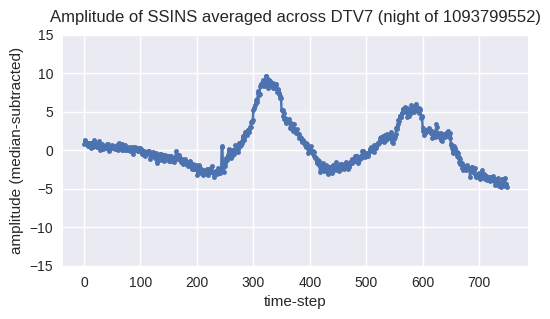

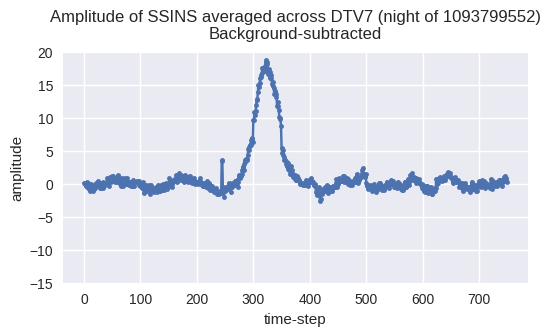

In [12]:
plt.figure(figsize=(6,3))
plt.plot(ssins, '.-')
plt.title("Amplitude of SSINS averaged across DTV7 (night of 1093799552)", y=1.02)
plt.xlabel("time-step")
plt.ylabel("amplitude (median-subtracted)")
# plt.yscale('symlog')
plt.ylim(-15,15)
# plt.savefig("./sample.png",dpi=300,bbox_inches='tight')
plt.show()

plt.figure(figsize=(6,3))
plt.plot(subtracted_data, '.-')
plt.title("Amplitude of SSINS averaged across DTV7 (night of 1093799552)\nBackground-subtracted", y=1.02)
plt.xlabel("time-step")
plt.ylabel("amplitude")
# plt.yscale('symlog')
plt.ylim(-15,20)
# plt.savefig("./sample.png",dpi=300,bbox_inches='tight')
plt.show()

In [8]:
# Structure the data for Stan
stan_data = {
    "N": subtracted_data.shape[0],
    "y": subtracted_data.tolist(),
}

In [9]:
stan_data

{'N': 750,
 'y': [0.04466051632584822,
  0.11923357091836806,
  -0.02133301185324399,
  -0.1461706315610627,
  -0.40110993046630483,
  -0.4951897911313381,
  0.25047379930458646,
  0.10642135461375801,
  -0.7963152525278474,
  -0.5247700743869927,
  -1.0949536716902912,
  -0.58025447731859,
  -0.2830177612815987,
  0.002606681902989294,
  -0.9801931878491814,
  -1.1291235199098537,
  -0.642943619621974,
  -0.8207955695812643,
  -0.14874724922640326,
  -0.24736746769201545,
  -0.5759028705430183,
  -0.33041284121168246,
  0.10705446926851891,
  -0.15626847238388564,
  0.37056151646197577,
  -0.10901058552826726,
  0.0015269721386630408,
  -0.023639058590219975,
  0.07991269889862451,
  -0.5857637215738123,
  -0.6950810810598114,
  -0.20931966141677094,
  -0.3617777915399074,
  -0.6169212850209078,
  0.19554380151566875,
  -0.2828796555465942,
  0.0319742870956361,
  -0.02445043764089405,
  -0.07777808604953407,
  -0.08925084924840121,
  0.22920726036772976,
  0.8663781952600402,
  0.416

In [10]:
# Write to JSON
with open("../data/three_state.data.json", "w") as f:
    json.dump(stan_data, f)

In [11]:
np.median(subtracted_data)

0.10490011166552904